In [ ]:
# (Python 3.12.0)

## Common libraries
import numpy as np
import pandas as pd
import pandas_ta as ta # Technical indicator library

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Datetime
import datetime as dt
from datetime import timedelta

## Libraires for ARIMA
import statsmodels # Statistical package
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller # ADF test for stationarity
from statsmodels.tsa.stattools import arma_order_select_ic 
import pmdarima as pm # auto_arima (does not work with recent Python versions)

## sklearn libraries
from sklearn.preprocessing import Normalizer, MinMaxScaler # Data transformation
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score # Metrics
from sklearn.feature_selection import RFE # RFE Feature selection

## XGBoost for RFE Feature Selection
from xgboost import XGBRegressor

## Neural network library
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers # Regularization during training
import keras_tuner # Hyperparameter tuning
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings('ignore')

import gc

In [ ]:
## Import the data
link= "https://raw.githubusercontent.com/vicdotcom/My-Datasets/refs/heads/main/SCOM.csv"

data= pd.read_csv(link)
# Convertng to datetime
data['Date']= pd.to_datetime(data['Date'])

# Sort from earliest to latest
data= data.reindex(index= data.index[::-1])
data.reset_index(inplace= True)
data.drop(['index'], axis= 1, inplace= True)

# Remove whitespace from columns
data.columns= data.columns.str.strip()

print(data.columns)
data.head(10)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Volume
0,2010-01-04,4.55,4.55,4.55,4.55,2802800
1,2010-01-05,4.55,4.60,4.60,4.60,1965900
2,2010-01-06,4.60,4.80,4.80,4.80,3856500
3,2010-01-07,4.80,4.95,4.95,4.95,22382600
4,2010-01-08,4.95,5.00,5.00,5.00,37595102
5,2010-01-11,5.00,5.05,5.05,5.05,20471900
6,2010-01-12,5.05,5.15,5.15,5.15,52153000
7,2010-01-13,5.15,5.40,5.40,5.40,31640600
8,2010-01-14,5.40,5.75,5.75,5.75,34234301
9,2010-01-15,5.75,5.55,5.55,5.55,27798801


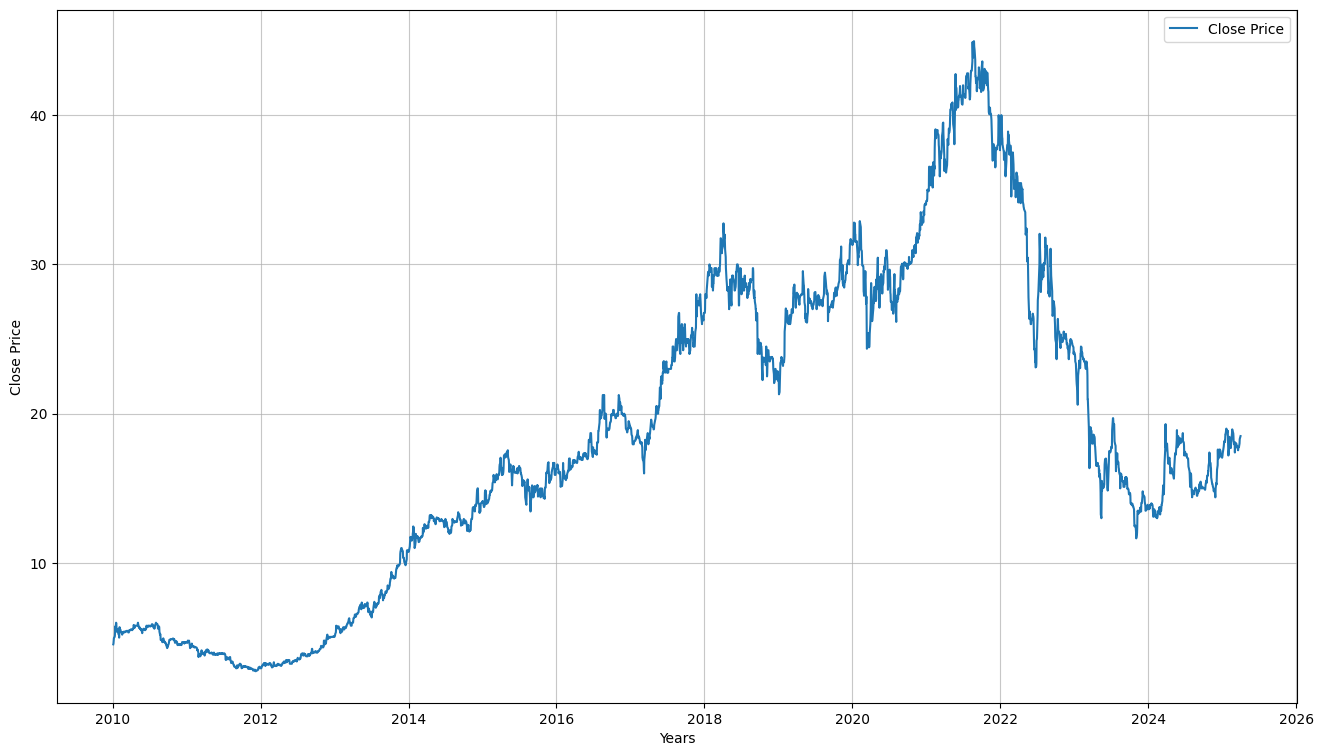

In [ ]:
## Plotting the data
plt.figure(figsize= (16,9))
plt.plot(data['Date'], data['Close'], label= 'Close Price')

plt.xlabel('Years')
plt.ylabel('Close Price')
plt.legend()
plt.grid(alpha= 0.7)

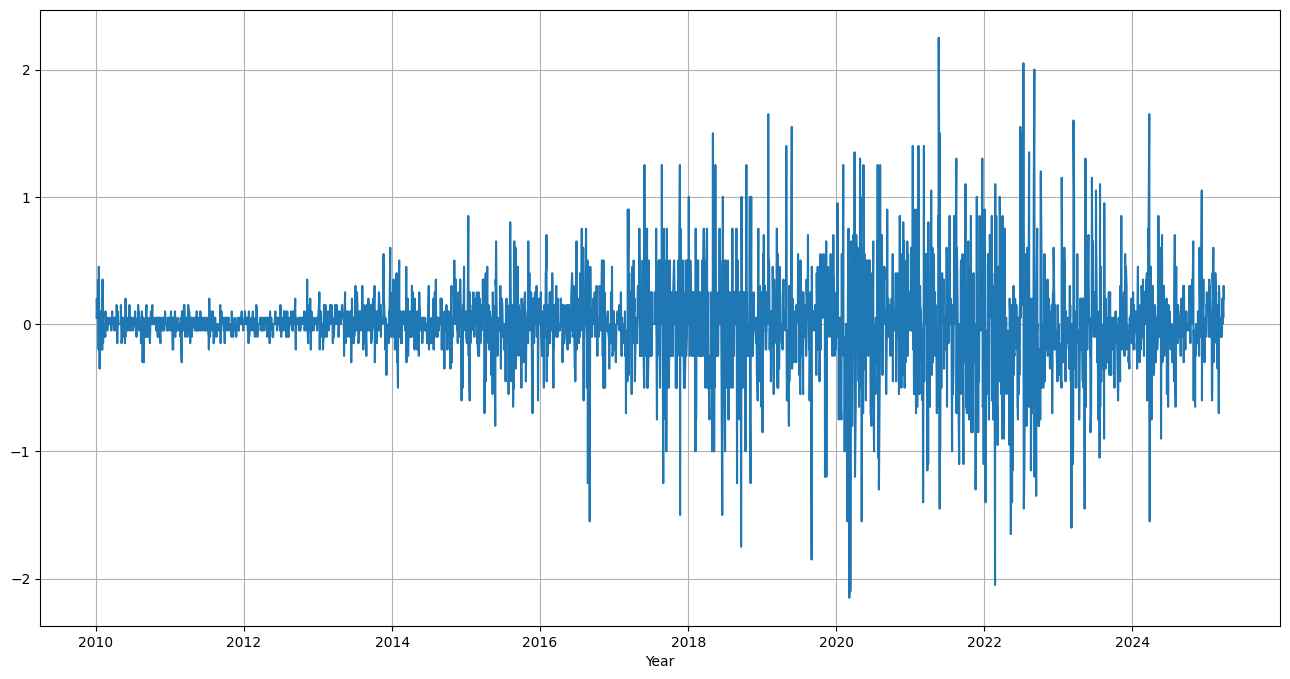

In [ ]:
plt.figure(figsize= (16,8))
plt.plot(data['Date'][:-1], data['Close'].diff().dropna())

plt.xlabel('Year')
plt.grid()

### Stationarity Check
We first check whether the time-series data is stationary using the Augmented Dickey-Fuller test. We shall also perform one after differencing. The results of the test are as follows:

1. Test statistic
    - Measures how strongly a unit root is present in the time series.
    - A more negative value indicates stronger evidence against the null hypothesis of a unit root (non-stationarity).

2. p-value
    - This is the probability of observing the test statistic under the null hypothesis. A very small p-value (less than 5%, 1%, 10% indicates that the null hypothesis can be rejected). Note that a p-value above 0 means there is some probability that the data is not stationary

3. No. of lags
    - Used to account for autocorrelation in the series

4. No. of observations

5. Critical Values (at the 1%, 5%, 10% level of significance || 99%, 95%, 90% confidence)
    - Compare the test statistic to the critical values to determine stationarity. If the test statistic is less than the critical value (e.g., more negative), the null hypothesis can be rejected at that significance level.

6. Maximum information criterion (Akaike Information Criterion)
    - It measures the goodness of fit while penalizing for model complexity. Lower values indicate a better balance between fit and complexity.


- So a time series is stationary if:
    - p-value is less than the level of significance
    - Test statistic is less than critical value
    

In [ ]:
prices= data['Close']

In [ ]:
## Dickey fuller test for non-stationary data
print('Raw Close Price ADF')
adfuller(prices)

Raw Close Price ADF


(-1.3828549411847957,
 0.5904675182731332,
 5,
 3806,
 {'1%': -3.4320693157877544,
  '5%': -2.8622996992165364,
  '10%': -2.5671743978048323},
 2377.033629800295)

In [ ]:
## Dickey fuller test for differenced data (Raw returns)
print('Returns')
adfuller(prices.diff().dropna())

Returns


(-29.789827213503425,
 0.0,
 4,
 3806,
 {'1%': -3.4320693157877544,
  '5%': -2.8622996992165364,
  '10%': -2.5671743978048323},
 2377.2555883780205)

In [ ]:
## Dickey Fuller diff 2
adfuller(prices.diff().diff().dropna())
 # Note noticable drop in AIC

(-19.914178035150435,
 0.0,
 30,
 3779,
 {'1%': -3.432081608223884,
  '5%': -2.862305129189198,
  '10%': -2.567177288520333},
 2499.715807415663)

Differenced data is indeed non-stationary. It is very closely matched to white noise as per the below plot.

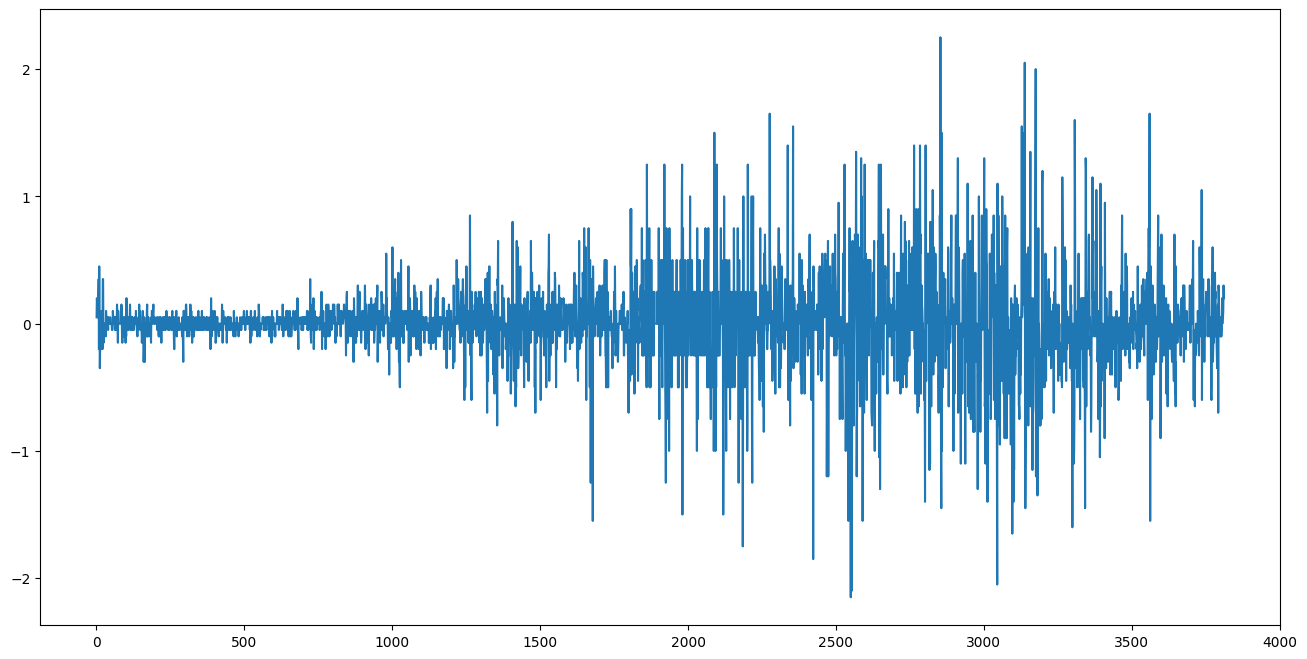

In [ ]:
plt.figure(figsize= (16,8))
plt.plot(prices.diff().dropna())

### Fitting an Ideal ARIMA Model
Fitting refers to the process of estimating the ARIMA(p,d,q) parameters. We shall do this via grid search.

For starters, consider a simple ARIMA(1,1,1) as a control.

In [ ]:
## ARIMA (1,1,1)
simpleARIMA= ARIMA(prices, order= (1,1,1))
simpleARIMA= simpleARIMA.fit()
print(simpleARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3812
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1191.867
Date:                Fri, 01 Aug 2025   AIC                           2389.735
Time:                        22:27:09   BIC                           2408.472
Sample:                             0   HQIC                          2396.393
                               - 3812                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0841      0.043     -1.958      0.050      -0.168       0.000
ma.L1          0.3055      0.042      7.195      0.000       0.222       0.389
sigma2         0.1094      0.001     90.913      0.0

We can analyze model residuals to confirm goodness of fit. Ideally, a well-fit model should have:
- No discernible pattern in the residual plot (complete white noise)
- Histogram should be normally distributed (no skewness)
- If the residuals are normally distributed then all the points should lie along the red line
- The correlogram is simply an ACF plot. 95% of the correlations for lag greater than zero should not be significant. If there are significant lagged correlations then it means there is information in the data that our model has not captured.

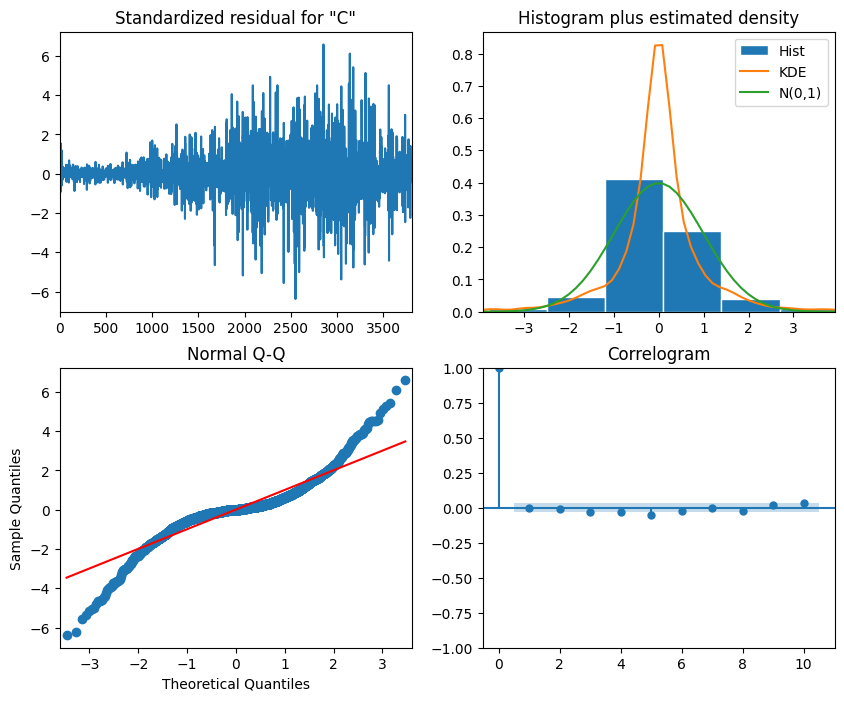

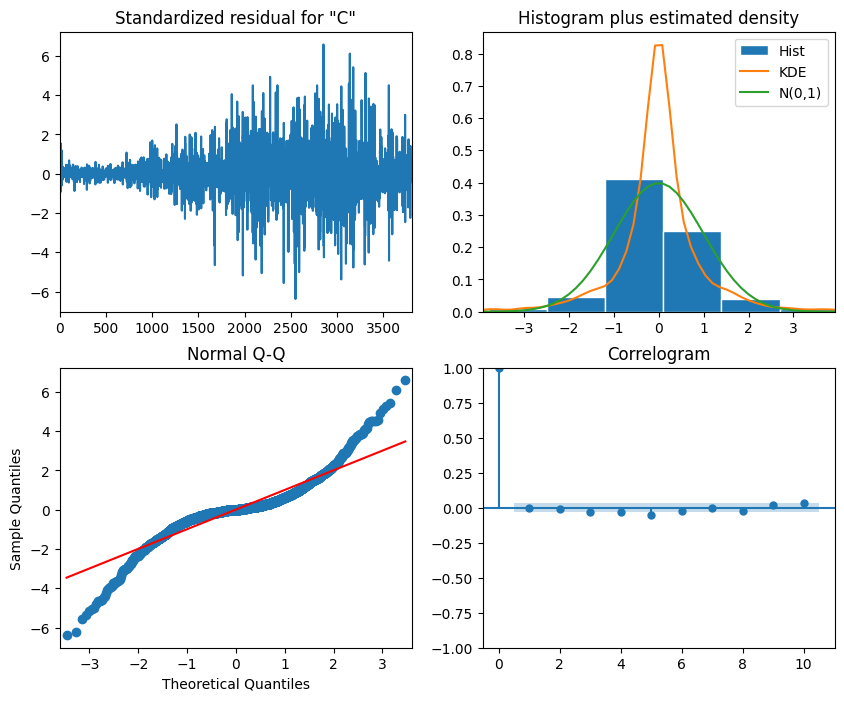

In [ ]:
simpleARIMA.plot_diagnostics(figsize= (10,8))

We can start by observing the ACF and PACF plots of the differenced price data to get a sense of the required (p,d,q) order of the model.


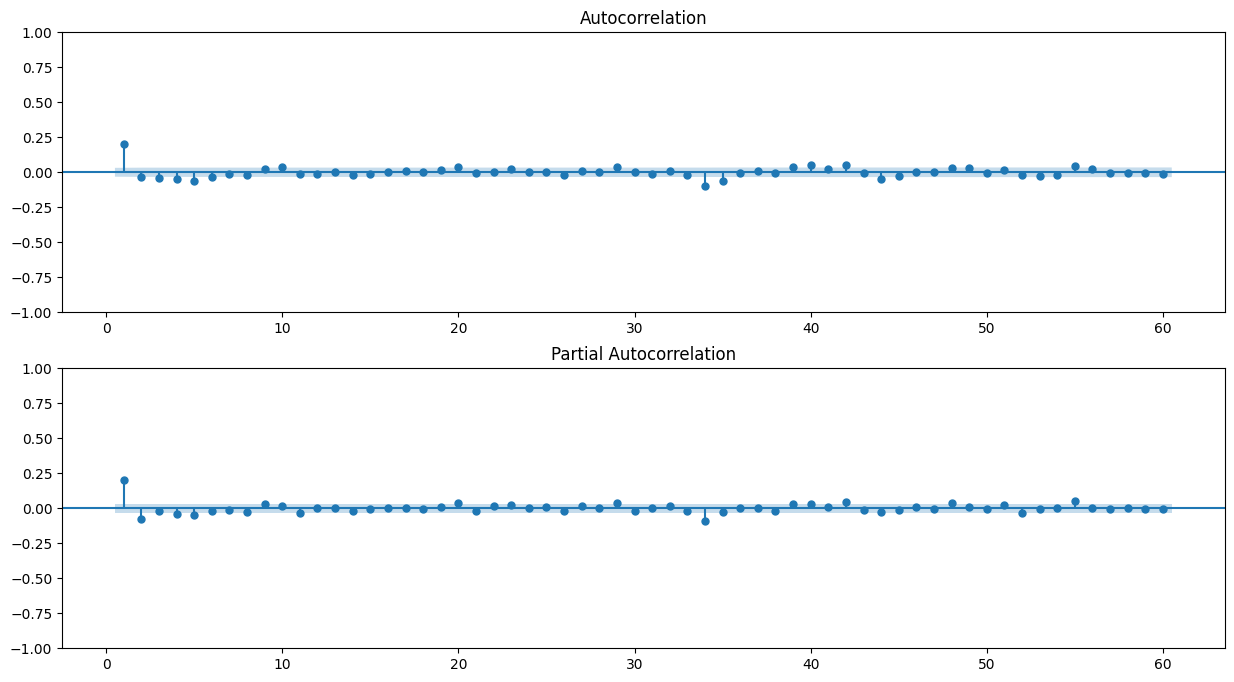

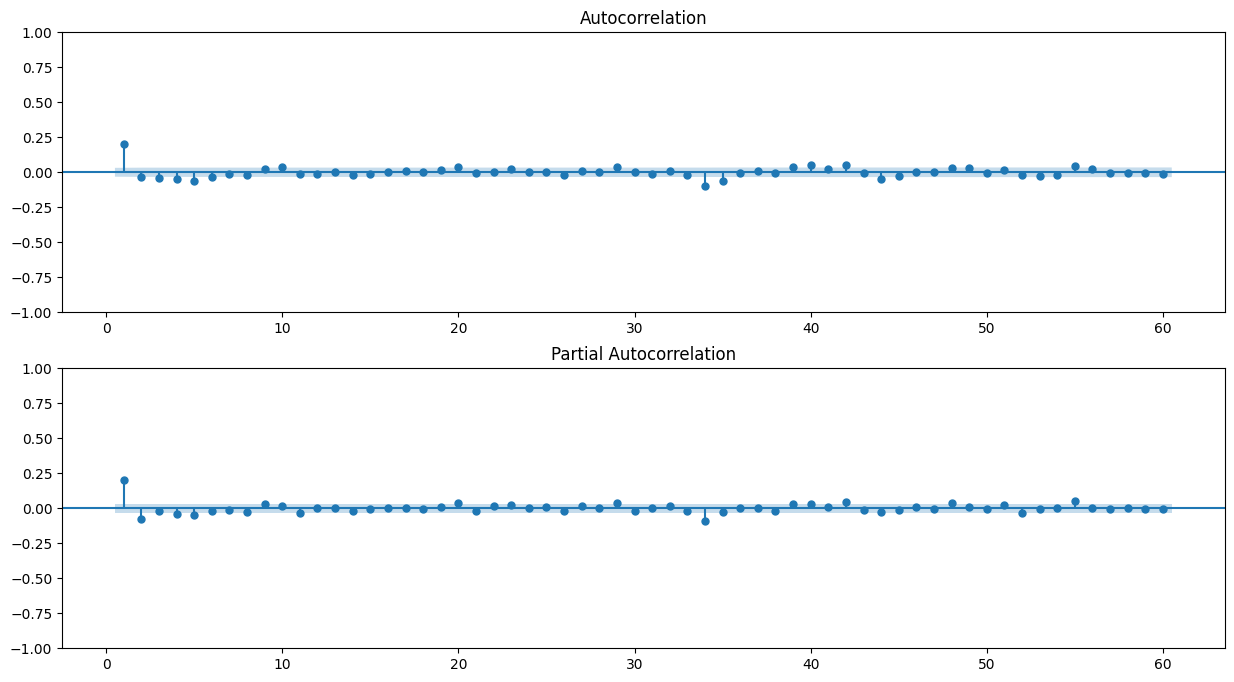

In [ ]:
## ACF, PACF of the differenced prices
prices_diff= prices.diff().dropna()

fig, (ax1, ax2)= plt.subplots(2,1, figsize= (15,8))

plot_acf(prices_diff, lags= 60, zero= False, alpha= 0.05, ax= ax1)
plot_pacf(prices_diff, lags= 60, zero= False, alpha= 0.05, ax= ax2)

To determine the best-fitting ARIMA(p,d,q) model, we shall use `pmdarima` package which automatically selects the best ARIMA model based on AIC/BIC criteria. The package uses a stepwise algorithm to search through the parameter space and find the optimal combination of p, d, and q values.

First we split the data into training and testing sets. We will fit the ARIMA model on the training set and evaluate its performance on the testing set. The training set will consist of the first 80% of the data, while the testing set will consist of the remaining 20%.

In [ ]:
## Splitting
n= 15 # No of days we will predict into the future

arima_train, arima_test= prices[:-n], prices[-n:]

In [ ]:
autoARIMA= pm.auto_arima(arima_train, d=1, 
                         start_P= 0, start_q= 0, 
                         max_p= 10, max_q= 10,
                         information_criterion= 'aic',
                         error_action= 'ignore', # Ignore orders that don't work
                         stepwise= False)

In [ ]:
## Release unwanted memory after a computationally heavy task
gc.collect()

3447

In [ ]:
print(autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3797
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1183.121
Date:                Fri, 01 Aug 2025   AIC                           2380.242
Time:                        22:35:12   BIC                           2423.934
Sample:                             0   HQIC                          2395.771
                               - 3797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.002      0.623      0.533      -0.003       0.005
ar.L1          0.8550      0.101      8.463      0.000       0.657       1.053
ar.L2         -0.2191      0.024     -8.977      0.0

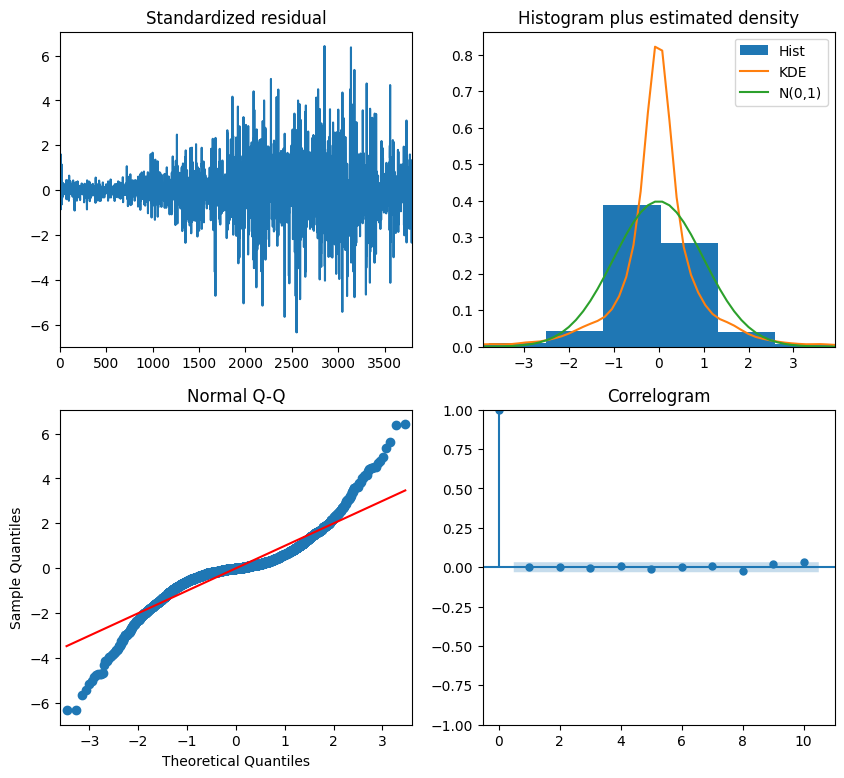

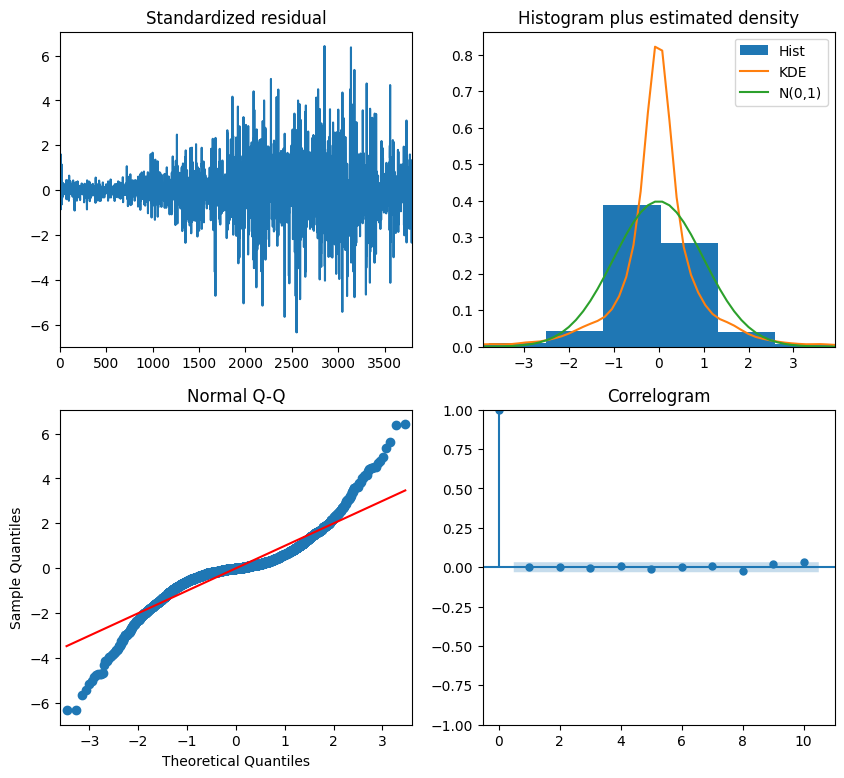

In [ ]:
autoARIMA.plot_diagnostics(figsize= (10,9))

### Predictions

In [ ]:
len(arima_train)

3797

In [ ]:
## In sample predictions
autoARIMA_forecast= autoARIMA.predict_in_sample()

autoARIMA_forecast

0        0.003499
1        4.553499
2        4.613008
3        4.843181
4        4.970010
          ...    
3792    18.170618
3793    17.258004
3794    17.841050
3795    17.993693
3796    18.086747
Name: predicted_mean, Length: 3797, dtype: float64

In [ ]:
## Predicting for the next n days (length of the test data)

# Forecasts
autoARIMA_pred= autoARIMA.predict(n_periods= n)
 # .predict() is used as autoARIMA is a pmdarima object
 # otherwise .get_forecast(steps= n) would be used

# Confidence interval
autoARIMA_limits= autoARIMA.conf_int()

# Predicted values
autoARIMA_pred.head()

3797    17.990790
3798    17.989451
3799    17.985461
3800    17.985205
3801    17.987434
dtype: float64

In [ ]:
## Actual prices (Out of sample)
actual_prices= arima_test
actual_prices

3797    18.00
3798    17.95
3799    17.85
3800    17.75
3801    17.80
3802    17.70
3803    17.60
3804    17.55
3805    17.75
3806    17.75
3807    17.85
3808    17.90
3809    18.00
3810    18.30
3811    18.50
Name: Close, dtype: float64

In [ ]:
len(prices) *0.2

762.4000000000001

Interestingly, ARIMA is able to capture the stock price trend. 

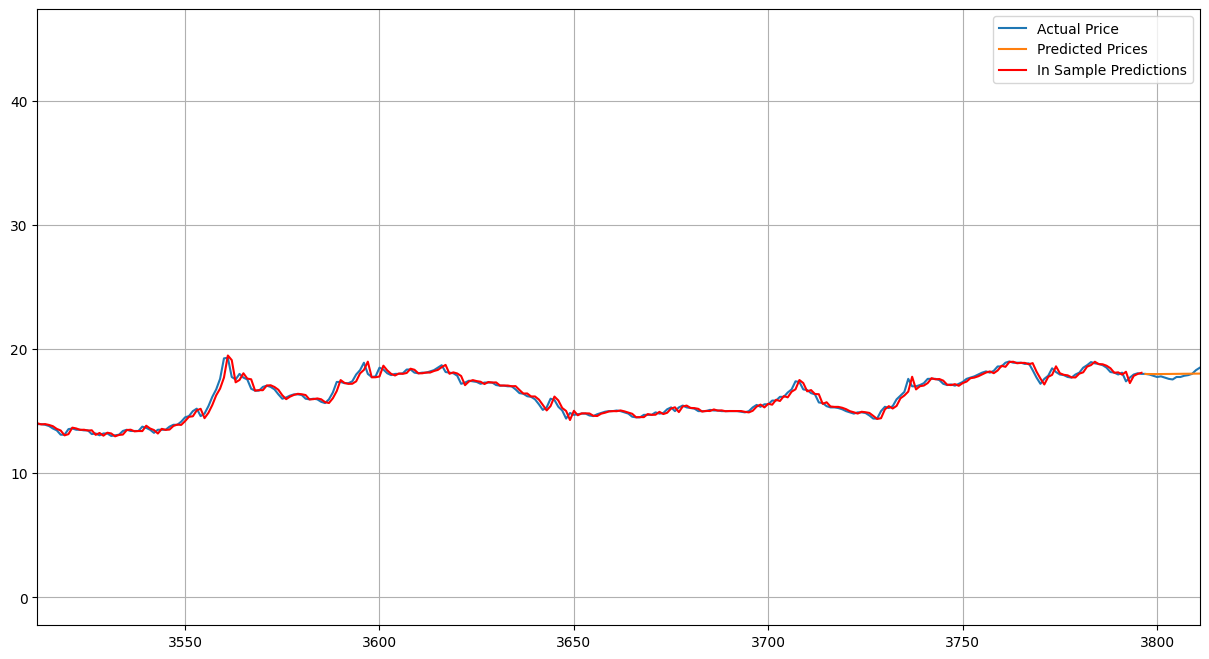

In [ ]:
## Plotting the ARIMA predictions
plt.figure(figsize= (15,8))

plt.plot(prices, label= 'Actual Price')
plt.plot(autoARIMA_pred, label= 'Predicted Prices')
plt.plot(autoARIMA_forecast, label= 'In Sample Predictions', color= 'red')

plt.xlim(prices.index[-300], prices.index[-1])


plt.legend()
plt.grid()

In [ ]:
## Predicted prices dataset
arima_predictions= pd.concat([autoARIMA_pred.reset_index(), actual_prices.reset_index()], axis= 'columns')
arima_predictions= arima_predictions.reset_index().drop(columns= ['index', 'level_0'])
arima_predictions.rename(columns={0: 'Predicted', ' Close': 'Actual'}, inplace=True)
arima_predictions['Residuals']= arima_predictions['Close']-arima_predictions['Predicted'] # Out of sample ARIMA residuals
arima_predictions

,Predicted,Close,Residuals
0,17.990790,18.00,0.009210
1,17.989451,17.95,-0.039451
2,17.985461,17.85,-0.135461
3,17.985205,17.75,-0.235205
4,17.987434,17.80,-0.187434
5,17.990543,17.70,-0.290543
6,17.994124,17.60,-0.394124
7,17.997874,17.55,-0.447874
8,18.001604,17.75,-0.251604
9,18.005264,17.75,-0.255264


In [ ]:
# Compute metrics
mse = mean_squared_error(arima_predictions['Close'], arima_predictions['Predicted'])
rmse = root_mean_squared_error(arima_predictions['Close'], arima_predictions['Predicted'])
mae = mean_absolute_error(arima_predictions['Close'], arima_predictions['Predicted'])
mape = mean_absolute_percentage_error(arima_predictions['Close'], arima_predictions['Predicted'])

# Print results
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

MSE: 0.06824725315748448
RMSE: 0.261241752324326
MAE: 0.21940113864979124
MAPE: 0.012276510324487264


In [ ]:
# We want to feed in sample predictions into the LSTM model
# residuals= pd.concat([autoARIMA.arima_res_.resid, arima_predictions['Residuals']], axis= 'rows')
in_sample_residuals= autoARIMA.arima_res_.resid
in_sample_residuals

0       4.546501
1       0.046501
2       0.186992
3       0.106819
4       0.029990
          ...   
3792   -0.770618
3793    0.441996
3794    0.108950
3795    0.056307
3796   -0.086747
Length: 3797, dtype: float64

In [ ]:
full_residuals= pd.concat([in_sample_residuals, arima_predictions['Residuals']], axis= 'rows')
full_residuals.reset_index(drop= True, inplace= True)
full_residuals.tail(15)

3797    0.009210
3798   -0.039451
3799   -0.135461
3800   -0.235205
3801   -0.187434
3802   -0.290543
3803   -0.394124
3804   -0.447874
3805   -0.251604
3806   -0.255264
3807   -0.158858
3808   -0.112403
3809   -0.015918
3810    0.280581
3811    0.477086
dtype: float64

In [ ]:
full_arima_prices= pd.concat([autoARIMA_forecast, autoARIMA_pred], axis= 'rows')
full_arima_prices.reset_index(drop= True, inplace= True)
full_arima_prices.tail(15)

3797    17.990790
3798    17.989451
3799    17.985461
3800    17.985205
3801    17.987434
3802    17.990543
3803    17.994124
3804    17.997874
3805    18.001604
3806    18.005264
3807    18.008858
3808    18.012403
3809    18.015918
3810    18.019419
3811    18.022914
dtype: float64

In [ ]:
lstm_data= pd.DataFrame(pd.concat([full_arima_prices, prices], axis='columns'))
lstm_data.rename(columns={0: 'ARIMA_Prices'}, inplace= True)
lstm_data[['Open', 'High', 'Low', 'Volume']]= data[['Open', 'High', 'Low', 'Volume']]
lstm_data

,ARIMA_Prices,Close,Open,High,Low,Volume
0,0.003499,4.55,4.55,4.55,4.55,2802800
1,4.553499,4.60,4.55,4.60,4.60,1965900
2,4.613008,4.80,4.60,4.80,4.80,3856500
3,4.843181,4.95,4.80,4.95,4.95,22382600
4,4.970010,5.00,4.95,5.00,5.00,37595102
...,...,...,...,...,...,...
3807,18.008858,17.85,18.00,18.00,17.75,7973300
3808,18.012403,17.90,17.90,18.10,17.80,7378100
3809,18.015918,18.00,18.00,18.20,17.90,1445000
3810,18.019419,18.30,18.15,18.45,18.00,9457500


Checking null values

In [ ]:
lstm_data.isnull().sum()

ARIMA_Prices    0
Close           0
Open            0
High            0
Low             0
Volume          0
dtype: int64

-------------------

# LSTM Prediction

#### Lagged Versions of Price

In [ ]:
lagNames= ['Close (1)', 'Close (2)', 'Close (3)', 'Close (4)', 'Close (5)']
shifts= [-1,-2,-3,-4,-5]

for l,i in zip(lagNames ,shifts):
    lstm_data[l]= lstm_data['Close'].shift(i)

In [ ]:
print(lstm_data.isnull().sum()) # 5 null values

lstm_data.dropna(inplace= True)
lstm_data.head()
 # Null values observed due to the lagging

ARIMA_Prices    0
Close           0
Open            0
High            0
Low             0
Volume          0
Close (1)       1
Close (2)       2
Close (3)       3
Close (4)       4
Close (5)       5
dtype: int64


,ARIMA_Prices,Close,Open,High,Low,Volume,Close (1),Close (2),Close (3),Close (4),Close (5)
0,0.003499,4.55,4.55,4.55,4.55,2802800,4.60,4.80,4.95,5.00,5.05
1,4.553499,4.60,4.55,4.60,4.60,1965900,4.80,4.95,5.00,5.05,5.15
2,4.613008,4.80,4.60,4.80,4.80,3856500,4.95,5.00,5.05,5.15,5.40
3,4.843181,4.95,4.80,4.95,4.95,22382600,5.00,5.05,5.15,5.40,5.75
4,4.970010,5.00,4.95,5.00,5.00,37595102,5.05,5.15,5.40,5.75,5.55


### Technical Indicator variables

In [ ]:
## Moving Averages
lstm_data['SMA5'] = ta.sma(lstm_data['Close'], length=5)
lstm_data['SMA10'] = ta.sma(lstm_data['Close'], length=10)
lstm_data['SMA15'] = ta.sma(lstm_data['Close'], length=15)
lstm_data['SMA20'] = ta.sma(lstm_data['Close'], length=20)

lstm_data['EMA5'] = ta.ema(lstm_data['Close'], length=5)
lstm_data['EMA10'] = ta.ema(lstm_data['Close'], length=10)
lstm_data['EMA15'] = ta.ema(lstm_data['Close'], length=15)
lstm_data['EMA20'] = ta.ema(lstm_data['Close'], length=20)

lstm_data['TRIMA5'] = ta.trima(lstm_data['Close'], length=5)
lstm_data['TRIMA10'] = ta.trima(lstm_data['Close'], length=10)
lstm_data['TRIMA20'] = ta.trima(lstm_data['Close'], length=20)

lstm_data['KAMA10'] = ta.kama(lstm_data['Close'], length=10)
lstm_data['KAMA20'] = ta.kama(lstm_data['Close'], length=20)
lstm_data['KAMA30'] = ta.kama(lstm_data['Close'], length=30)

## MACD
macd= ta.macd(lstm_data['Close'])

# EMV (Ease of Movement) requires 'High', 'Low', 'Close', and 'Volume' columns
lstm_data['EMV']= ta.eom(high=lstm_data['High'], low=lstm_data['Low'], close=lstm_data['Close'], volume=lstm_data['Volume'])

# Directional Movement Index (DMI)
adx5 = ta.adx(lstm_data['High'], lstm_data['Low'], lstm_data['Close'], length=5)
adx5.columns = ['ADX5', 'DMP5', 'DMN5']
lstm_data = lstm_data.join(adx5)

adx10 = ta.adx(lstm_data['High'], lstm_data['Low'], lstm_data['Close'], length=10)
adx10.columns = ['ADX10', 'DMP10', 'DMN10']
lstm_data = lstm_data.join(adx10)

adx20 = ta.adx(lstm_data['High'], lstm_data['Low'], lstm_data['Close'], length=20)
adx20.columns = ['ADX20', 'DMP20', 'DMN20']
lstm_data = lstm_data.join(adx20)

# Stochastic Oscillator (KDJ)
stoch = ta.stoch(lstm_data['High'], lstm_data['Low'], lstm_data['Close'], k=14, d=3, smooth_k=3)
stoch.columns = ['STOCHk', 'STOCHd']
lstm_data = lstm_data.join(stoch)

# Relative Strength Index (RSI)
lstm_data['RSI14'] = ta.rsi(lstm_data['Close'], length=14)
lstm_data['RSI8'] = ta.rsi(lstm_data['Close'], length=8)

# Rate of Change
lstm_data['ROC']= ta.roc(lstm_data['Close'])

# Percentage Volume Oscillator (PVO)
pvo= ta.pvo(lstm_data['Volume'])

# On-Balance Volume (OBV)
lstm_data['OBV']= ta.obv(lstm_data['Close'],lstm_data['Volume'])

# Bolinger Bands (BOLL)
bbands = ta.bbands(lstm_data['Close'], length=20)
bbands.columns = ['BBL_20', 'BBM_20', 'BBU_20', 'BBB_20', 'BBP_20']
lstm_data = lstm_data.join(bbands)

# MACD
macd_510 = ta.macd(lstm_data['Close'], fast=5, slow=10)
macd_510.columns = ["MACD510", "MACD510_hist", "MACD510_signal"]
lstm_data = lstm_data.join(macd_510)

macd_520 = ta.macd(lstm_data['Close'], fast=5, slow=20)
macd_520.columns = ["MACD520", "MACD520_hist", "MACD520_signal"]
lstm_data = lstm_data.join(macd_520)

macd_1020 = ta.macd(lstm_data['Close'], fast=10, slow=20)
macd_1020.columns = ["MACD1020", "MACD1020_hist", "MACD1020_signal"]
lstm_data = lstm_data.join(macd_1020)

macd_1520 = ta.macd(lstm_data['Close'], fast=15, slow=20)
macd_1520.columns = ["MACD1520", "MACD1520_hist", "MACD1520_signal"]
lstm_data = lstm_data.join(macd_1520)

macd_1226 = ta.macd(lstm_data['Close'], fast=12, slow=26)
macd_1226.columns = ["MACD1226", "MACD1226_hist", "MACD1226_signal"]
lstm_data = lstm_data.join(macd_1226)

## Momentum
lstm_data['MOM10'] = ta.mom(lstm_data['Close'], length=10)
lstm_data['MOM15'] = ta.mom(lstm_data['Close'], length=15)
lstm_data['MOM20'] = ta.mom(lstm_data['Close'], length=20)

lstm_data['ROC5'] = ta.roc(lstm_data['Close'], length=5)
lstm_data['ROC10'] = ta.roc(lstm_data['Close'], length=10)
lstm_data['ROC20'] = ta.roc(lstm_data['Close'], length=20)

# PPO
ppo = ta.ppo(lstm_data['Close'])
ppo.columns = ['PPO', 'PPO_hist', 'PPO_signal']
lstm_data = lstm_data.join(ppo)

# ATR
lstm_data['ATR'] = ta.atr(lstm_data['High'], lstm_data['Low'], lstm_data['Close'], length=14)

# Ultimate Oscillator
lstm_data['ULTOSC'] = ta.uo(lstm_data['High'], lstm_data['Low'], lstm_data['Close'])

# Williams %R
lstm_data['WILLR'] = ta.willr(lstm_data['High'], lstm_data['Low'], lstm_data['Close'])

# True Range
lstm_data['TRange'] = lstm_data['High'] - lstm_data['Low']

# Typical Price
lstm_data['TYPPRICE'] = (lstm_data['High'] + lstm_data['Low'] + lstm_data['Close']) / 3

lstm_data.dropna(inplace=True)
lstm_data.reset_index(drop= True, inplace= True)



In [ ]:
lstm_data

,ARIMA_Prices,Close,Open,High,Low,Volume,Close (1),Close (2),Close (3),Close (4),...,ROC10,ROC20,PPO,PPO_hist,PPO_signal,ATR,ULTOSC,WILLR,TRange,TYPPRICE
0,5.412773,5.40,5.40,5.40,5.40,17827301,5.35,5.40,5.40,5.40,...,0.934579,2.857143,-0.981092,-0.089872,-0.891220,0.074535,74.231806,-33.333333,0.00,5.400000
1,5.398472,5.35,5.40,5.35,5.35,9327800,5.40,5.40,5.40,5.40,...,0.000000,2.884615,-0.910389,-0.015336,-0.895054,0.072687,54.867827,-25.000000,0.00,5.350000
2,5.341635,5.40,5.35,5.40,5.40,10131400,5.40,5.40,5.40,5.40,...,1.886792,8.000000,-0.726710,0.134675,-0.861385,0.070985,59.523810,0.000000,0.00,5.400000
3,5.415673,5.40,5.40,5.40,5.40,9291900,5.40,5.40,5.40,5.40,...,3.846154,0.934579,-0.542636,0.254999,-0.797635,0.065679,60.944998,0.000000,0.00,5.400000
4,5.398184,5.40,5.40,5.40,5.40,6371900,5.40,5.40,5.40,5.45,...,1.886792,-5.263158,-0.280564,0.413657,-0.694221,0.060785,60.588463,0.000000,0.00,5.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,17.990543,17.70,17.75,17.90,17.50,12208600,17.60,17.55,17.75,17.75,...,1.724138,-5.347594,-1.431504,-0.656473,-0.775031,0.501841,47.631688,-55.172414,0.40,17.700000
3761,17.994124,17.60,17.70,17.85,17.45,468400,17.55,17.75,17.75,17.85,...,-0.564972,-7.124011,-1.630204,-0.684139,-0.946065,0.494567,45.511484,-62.068966,0.40,17.633333
3762,17.997874,17.55,17.60,17.80,17.45,355700,17.75,17.75,17.85,17.90,...,-2.228412,-6.896552,-1.529799,-0.466987,-1.062812,0.484241,43.073818,-65.517241,0.35,17.600000
3763,18.001604,17.75,17.80,18.00,17.55,3201300,17.75,17.85,17.90,18.00,...,-1.662050,-5.585106,-1.464909,-0.321678,-1.143232,0.481795,45.119409,-51.724138,0.45,17.766667


In [ ]:
lstm_data.isnull().sum()

ARIMA_Prices    0
Close           0
Open            0
High            0
Low             0
               ..
ATR             0
ULTOSC          0
WILLR           0
TRange          0
TYPPRICE        0
Length: 75, dtype: int64

Replacing inf values with zero as inf was obtained by dividing by zero in the technical indicator columns.

### Data Splitting

First step before any transformation, feature selection, etc is to split the data into training and testing sets in order to avoid data leakage from the training set to the testing set. The testing set represents data we have not seen before so it should remain completely untouched. We apply an 80-20 ratio

In [ ]:
split= int(len(lstm_data) * 0.8) 
train, test= lstm_data[:split], lstm_data[split:]
# Split the data sequentially as we are dealing with time series

test

,ARIMA_Prices,Close,Open,High,Low,Volume,Close (1),Close (2),Close (3),Close (4),...,ROC10,ROC20,PPO,PPO_hist,PPO_signal,ATR,ULTOSC,WILLR,TRange,TYPPRICE
3012,35.928826,35.10,36.05,36.05,34.90,5545700,35.05,35.50,35.50,35.65,...,-4.098361,-8.355091,-2.417303,-1.155014,-1.262288,1.135925,44.895985,-73.750000,1.15,35.350000
3013,34.926926,35.05,35.10,35.50,34.80,9826100,35.50,35.50,35.65,35.40,...,1.447178,-9.431525,-2.787402,-1.220091,-1.567311,1.104788,44.430332,-75.000000,0.70,35.116667
3014,35.142076,35.50,35.20,36.00,35.20,1807600,35.50,35.65,35.40,34.95,...,-0.420757,-7.792208,-2.802689,-0.988302,-1.814387,1.093731,42.652326,-63.750000,0.80,35.566667
3015,35.653443,35.50,35.60,35.60,35.30,2714200,35.65,35.40,34.95,34.50,...,-1.251739,-6.824147,-2.336157,-0.417416,-1.918741,1.037036,41.245913,-61.333333,0.30,35.466667
3016,35.536465,35.65,35.60,36.80,35.30,3006700,35.40,34.95,34.50,35.50,...,-1.383126,-4.551539,-2.091909,-0.138534,-1.953374,1.070105,38.885936,-56.756757,1.50,35.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,17.990543,17.70,17.75,17.90,17.50,12208600,17.60,17.55,17.75,17.75,...,1.724138,-5.347594,-1.431504,-0.656473,-0.775031,0.501841,47.631688,-55.172414,0.40,17.700000
3761,17.994124,17.60,17.70,17.85,17.45,468400,17.55,17.75,17.75,17.85,...,-0.564972,-7.124011,-1.630204,-0.684139,-0.946065,0.494567,45.511484,-62.068966,0.40,17.633333
3762,17.997874,17.55,17.60,17.80,17.45,355700,17.75,17.75,17.85,17.90,...,-2.228412,-6.896552,-1.529799,-0.466987,-1.062812,0.484241,43.073818,-65.517241,0.35,17.600000
3763,18.001604,17.75,17.80,18.00,17.55,3201300,17.75,17.85,17.90,18.00,...,-1.662050,-5.585106,-1.464909,-0.321678,-1.143232,0.481795,45.119409,-51.724138,0.45,17.766667


### Data Transformation
As the variables are differently scaled, we use MinMax transformation to scale the variables between 0 and 1. We transform the training dataset and testing dataset separately to avoid data leakage

We also transform the input features and target variable sepetrately to avoid differing values from the original during `inverse_transform` later on.

In [ ]:
## Scalers
feature_scaler = MinMaxScaler(feature_range=(0,1)) # Scales the input feature
target_scaler = MinMaxScaler(feature_range=(0,1)) # Scales the target feature

## Scale the training and testing data separately to avoid data leakage
# Training Target feature dataset
target_scaled_train = target_scaler.fit_transform(train['Close'].values.reshape(-1, 1))
target_scaled_train_df = pd.DataFrame(target_scaled_train, columns=['Close'])

# Testing Target feeature dataset (No need to scale target testing data)
target_test_data= test['Close'].values
target_test_data_df = pd.DataFrame(target_test_data, columns=['Close'])


# Training Input feature dataset
train_features = train.drop(columns='Close')
train_scaled = feature_scaler.fit_transform(train_features)
train_scaled_df = pd.DataFrame(train_scaled, columns=train_features.columns)
# Add back the target feature (we do this to prevent dealing with multiple variables)
train_scaled_df['Close'] = target_scaled_train_df['Close'].values

# Testing Input feature dataset
test_features = test.drop(columns='Close')
test_scaled = feature_scaler.transform(test_features)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_features.columns)
# Add back the target feature
test_scaled_df['Close'] = target_test_data_df['Close'].values

# The two important variables we will use going further are 'train_scaled_df' and 'test_scaled_df'
test_scaled_df.head()


,ARIMA_Prices,Open,High,Low,Volume,Close (1),Close (2),Close (3),Close (4),Close (5),...,ROC20,PPO,PPO_hist,PPO_signal,ATR,ULTOSC,WILLR,TRange,TYPPRICE,Close
0,0.783167,0.788166,0.783274,0.779661,0.036079,0.765403,0.776066,0.776066,0.779621,0.773697,...,0.299871,0.418445,0.281438,0.479075,0.804761,0.429487,0.262500,0.383333,0.776410,35.10
1,0.759524,0.765680,0.770318,0.777240,0.064452,0.776066,0.776066,0.779621,0.773697,0.763033,...,0.275224,0.394105,0.271585,0.455446,0.782259,0.424137,0.250000,0.233333,0.770850,35.05
2,0.764601,0.768047,0.782097,0.786925,0.011300,0.776066,0.779621,0.773697,0.763033,0.752370,...,0.312759,0.393100,0.306679,0.436307,0.774269,0.403711,0.362500,0.266667,0.781573,35.50
3,0.776669,0.777515,0.772674,0.789346,0.017310,0.779621,0.773697,0.763033,0.752370,0.776066,...,0.334925,0.423781,0.393113,0.428223,0.733298,0.387555,0.386667,0.100000,0.779190,35.50
4,0.773908,0.777515,0.800942,0.789346,0.019249,0.773697,0.763033,0.752370,0.776066,0.791469,...,0.386961,0.439844,0.435337,0.425540,0.757195,0.360443,0.432432,0.500000,0.789913,35.65


### Feature Selection
First, we check the correlation heatmap between the features and the target variable (Close Price). Then we perform further feature selection via Recursive Feature Elimination (RFE) using XGBoost.

Recursive Feature Elimination works by recursively removing features that do not improve model performance. We select the best number of features that produce the lowest loss (MSE). 



In [ ]:
lstm_data.columns

Index(['ARIMA_Prices', 'Close', 'Open', 'High', 'Low', 'Volume', 'Close (1)',
       'Close (2)', 'Close (3)', 'Close (4)', 'Close (5)', 'SMA5', 'SMA10',
       'SMA15', 'SMA20', 'EMA5', 'EMA10', 'EMA15', 'EMA20', 'TRIMA5',
       'TRIMA10', 'TRIMA20', 'KAMA10', 'KAMA20', 'KAMA30', 'EMV', 'ADX5',
       'DMP5', 'DMN5', 'ADX10', 'DMP10', 'DMN10', 'ADX20', 'DMP20', 'DMN20',
       'STOCHk', 'STOCHd', 'RSI14', 'RSI8', 'ROC', 'OBV', 'BBL_20', 'BBM_20',
       'BBU_20', 'BBB_20', 'BBP_20', 'MACD510', 'MACD510_hist',
       'MACD510_signal', 'MACD520', 'MACD520_hist', 'MACD520_signal',
       'MACD1020', 'MACD1020_hist', 'MACD1020_signal', 'MACD1520',
       'MACD1520_hist', 'MACD1520_signal', 'MACD1226', 'MACD1226_hist',
       'MACD1226_signal', 'MOM10', 'MOM15', 'MOM20', 'ROC5', 'ROC10', 'ROC20',
       'PPO', 'PPO_hist', 'PPO_signal', 'ATR', 'ULTOSC', 'WILLR', 'TRange',
       'TYPPRICE'],
      dtype='object')

Variables with correlation >= 0.99 to 'Close': ['ARIMA_Prices', 'Open', 'High', 'Low', 'Close (1)', 'Close (2)', 'Close (3)', 'Close (4)', 'Close (5)', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'EMA5', 'EMA10', 'EMA15', 'EMA20', 'TRIMA5', 'TRIMA10', 'TRIMA20', 'KAMA10', 'KAMA20', 'KAMA30', 'BBL_20', 'BBM_20', 'BBU_20', 'TYPPRICE']
No. of highly correlated variables: 27


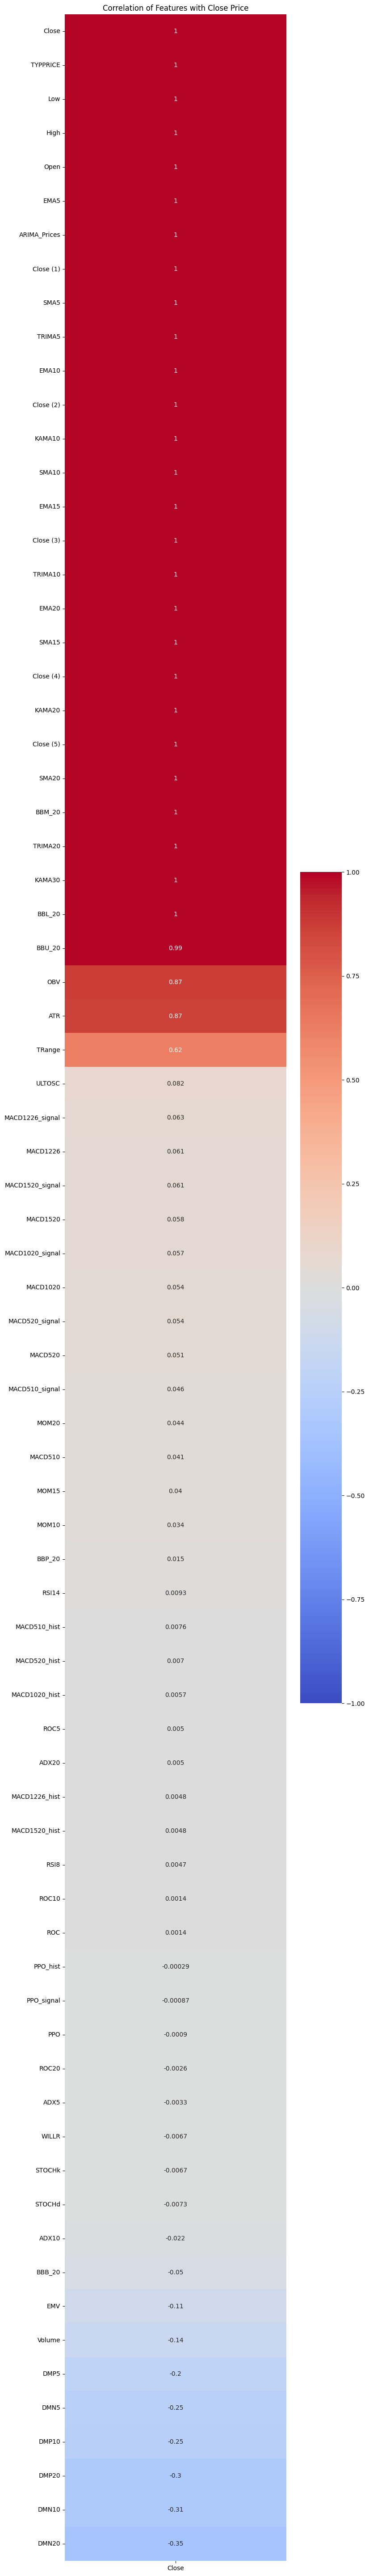

In [ ]:
corr_matrix = lstm_data.corr()

# Plot heatmap of all features correlated with Close price
plt.figure(figsize=(8, len(corr_matrix)-1))
sns.heatmap(
    corr_matrix[['Close']].sort_values(by='Close', ascending=False),
    annot=True, cmap='coolwarm', vmin=-1, vmax=1
)
plt.title('Correlation of Features with Close Price')

# Print variables with correlation >= 0.99 (excluding 'Close' itself)
high_corr = corr_matrix['Close'].drop('Close').abs()
high_corr_vars = high_corr[high_corr >= 0.99]
correlated_variables= list(high_corr_vars.index)
print("Variables with correlation >= 0.99 to 'Close':", correlated_variables)
print("No. of highly correlated variables:", len(correlated_variables))

The below code for RFE is divided into two blocks.
- Block 1 is for finding the best number of features. RFE is ran multiple times per n number of features and the MSE is recorded for each run. The best number of features is the one that produces the lowest MSE.
- Block 2 is for running the best number of features which proceed to the next stage.

In the below code for RFE, first run `#### Block 1 #####` with `#### Block 2 #####` commented out to find the best number of features. Then uncomment #### Block 2 ##### whie commenting out `#### Block 1 #####` and run `#### Block 2 #####` to get the results for the best number of features.

In [ ]:

## Data preparation for RFE
X_rfe= train_scaled_df[correlated_variables] # variables highly correlated with Close price (>0.99)
y_rfe= train_scaled_df['Close'] # Target variable

## Data splitting for RFE 
## We use only the training dataset for feature selection to avoid data leakage
rfe_split= int(len(train_scaled_df) * 0.2) 
xr_train, xr_test= X_rfe[:rfe_split], X_rfe[rfe_split:]
yr_train, yr_test= y_rfe[:rfe_split], y_rfe[rfe_split:]

## We define an XGBoost regression function to check the accuracy of the model with the selected features
def run_XG(xr_train, xr_test, yr_train, yr_test):
    regr= XGBRegressor(objective= 'reg:squarederror', # objective is to minimize mean squared error
                       n_estimators= 500, # 500 decision trees
                       learning_rate= 0.1, 
                       random_state= 42)
    regr.fit(xr_train, yr_train)
    yr_pred= regr.predict(xr_test)
    print('MSE Loss:', mean_squared_error(yr_test, yr_pred))



#### Block 1 #####

# ## For determining the optimum number of features
# results = []
# for features in range(2, len(X_rfe.columns)+1):
#     rfe = RFE(XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42), n_features_to_select=features)
#     rfe.fit(xr_train, yr_train)
#     xr1_train = rfe.transform(xr_train)
#     xr1_test = rfe.transform(xr_test)
#     regr = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.1, random_state=42)
#     regr.fit(xr1_train, yr_train)
#     yr_pred = regr.predict(xr1_test)
#     mse_loss = mean_squared_error(yr_test, yr_pred)
#     print(features)
#     print('MSE Loss:', mse_loss)
#     print()
#     results.append({'num_features': features, 'mse_loss': mse_loss})

# # Save results to CSV
# rfe_results = pd.DataFrame(results)
# rfe_results.to_csv('rfe_results.csv', index=False)



#### Block 2 #####

## After finding the best no of features
features= 16
rfe = RFE(XGBRegressor(objective='reg:squarederror', n_estimators=500, random_state=42), n_features_to_select=features, verbose= 1)
rfe.fit(xr_train, yr_train)
xr1_train = rfe.transform(xr_train)
xr1_test = rfe.transform(xr_test)
print(features)
run_XG(xr1_train, xr1_test, yr_train, yr_test)
print()

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
16
MSE Loss: 0.19921892811394643



We find 16 features produce the lowest MSE loss for predicting Close Price 

In [ ]:
gc.collect()

19759

We find 21 features produce the lowest MSE loss for predicting Close Price 

In [ ]:
## Selected Features
selected= np.where(rfe.support_== True)
print(selected)

for i in selected:
    print(xr_train.columns[i])
print()
print('Number of features selected:', len(selected[0]))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 16, 17, 18, 20, 25, 26],
      dtype=int64),)
Index(['ARIMA_Prices', 'Open', 'High', 'Low', 'Close (1)', 'Close (2)',
       'Close (3)', 'Close (4)', 'Close (5)', 'EMA5', 'EMA20', 'TRIMA5',
       'TRIMA10', 'KAMA10', 'BBU_20', 'TYPPRICE'],
      dtype='object')

Number of features selected: 16


In [ ]:
train_scaled_df

,ARIMA_Prices,Open,High,Low,Volume,Close (1),Close (2),Close (3),Close (4),Close (5),...,ROC20,PPO,PPO_hist,PPO_signal,ATR,ULTOSC,WILLR,TRange,TYPPRICE,Close
0,0.063026,0.062722,0.061249,0.065375,0.117488,0.061611,0.062796,0.062796,0.062796,0.062796,...,0.556598,0.512896,0.442705,0.507819,0.037737,0.766495,0.666667,0.000000,0.062748,0.062796
1,0.062689,0.062722,0.060071,0.064165,0.061149,0.062796,0.062796,0.062796,0.062796,0.062796,...,0.557227,0.517546,0.453990,0.507522,0.036402,0.544043,0.750000,0.000000,0.061557,0.061611
2,0.061348,0.061538,0.061249,0.065375,0.066475,0.062796,0.062796,0.062796,0.062796,0.062796,...,0.674354,0.529626,0.476702,0.510130,0.035172,0.597530,1.000000,0.000000,0.062748,0.062796
3,0.063095,0.062722,0.061249,0.065375,0.060911,0.062796,0.062796,0.062796,0.062796,0.063981,...,0.512577,0.541731,0.494920,0.515068,0.031337,0.613857,1.000000,0.000000,0.062748,0.062796
4,0.062682,0.062722,0.061249,0.065375,0.041555,0.062796,0.062796,0.062796,0.063981,0.063981,...,0.370667,0.558966,0.518941,0.523079,0.027801,0.609761,1.000000,0.000000,0.062748,0.062796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,0.791781,0.798817,0.817432,0.813559,0.069155,0.823460,0.823460,0.804502,0.789100,0.766588,...,0.454640,0.509323,0.302113,0.575541,0.807858,0.418671,0.634409,0.400000,0.814138,0.811611
3008,0.813209,0.818935,0.823322,0.830508,0.037182,0.823460,0.804502,0.789100,0.766588,0.765403,...,0.473005,0.501131,0.317866,0.557833,0.787716,0.406647,0.758242,0.250000,0.825655,0.823460
3009,0.821391,0.822485,0.822144,0.840194,0.048704,0.804502,0.789100,0.766588,0.765403,0.776066,...,0.461050,0.488234,0.321802,0.540628,0.745784,0.400249,0.775281,0.100000,0.828435,0.823460
3010,0.819092,0.820118,0.817432,0.812349,0.010940,0.789100,0.766588,0.765403,0.776066,0.776066,...,0.409940,0.466587,0.308835,0.521764,0.755885,0.446012,0.623529,0.416667,0.811358,0.804502


In [ ]:
## Target Variable data
train_target = train_scaled_df['Close'] # (y_train)
test_target=  test_scaled_df['Close']  # (y_test)


## Input variable data
selected= ['ARIMA_Prices', 'Open', 'High', 'Low', 'Close (1)', 'Close (2)',
       'Close (3)', 'Close (4)', 'Close (5)', 'SMA5', 'SMA20', 'EMA5', 'EMA10',
       'EMA15', 'EMA20', 'TRIMA5', 'TRIMA10', 'TRIMA20', 'KAMA10', 'KAMA20',
       'KAMA30', 'BBL_20', 'BBM_20', 'BBU_20', 'TYPPRICE']


train_scaled_df= train_scaled_df[selected]
test_scaled_df= test_scaled_df[selected]

print('x_train:', train_scaled_df.shape)
print('y_train:', test_scaled_df.shape)

print('x_test:', train_target.shape)
print('y_test:', test_target.shape)


x_train: (3012, 25)
y_train: (753, 25)
x_test: (3012,)
y_test: (753,)


Where column `Close` is the target variable to be predicted.

### LSTM Data Preparation
We create a time series model for LSTM by creating sequences of data. Each sequence will consist of a certain number of previous time steps (lookback period) to predict the next time step.

The input variable dataset will be structured in a 3D array consisting of (Number of samples, Time steps, Number of features). The number of time steps is the lookback period we choose.

The target variable will be a 2D array consisting of (Number of samples, Number of output features- 1 feature).

In [ ]:
## Convert the above data to pandas arrays (2D arrays)
# (n_samples, features)
train_variables= train_scaled_df.values 
test_variables= test_scaled_df.values

# (n_samples, target feature)
train_output= train_target.values.reshape(-1,1)
test_output= test_target.values.reshape(-1,1)

In [ ]:
train_variables.shape

(3012, 25)

We define a lookback window function that creates sequences of data based on the lookback period.


In [ ]:
## Sequencing data function
def sequences(input_data, target_feature_data, lookback_days):
    X, y = [], []
    for i in range(lookback_days, len(input_data)):
        X.append(input_data[i-lookback_days:i, :])
        y.append(target_feature_data[i])
    return np.array(X), np.array(y)

## Generate sequences for train/test sets
days = 24
x_train, y_train = sequences(train_variables, train_output, days)
x_test, y_test = sequences(test_variables, test_output, days)

## Verify data shapes
print('x_train Shape:', np.shape(x_train))
print('x_train Dimensions:', x_train.ndim)
print()
print('x_test Shape:', np.shape(x_test))
print('x_test Dimensions:', x_test.ndim)
print()
print('y_train Shape:', np.shape(y_train))
print('y_train Dimensions:', y_train.ndim)
print()
print('y_test Shape:', np.shape(y_test))
print('y_test Dimensions:', y_test.ndim)

x_train Shape: (2988, 24, 25)
x_train Dimensions: 3

x_test Shape: (729, 24, 25)
x_test Dimensions: 3

y_train Shape: (2988, 1)
y_train Dimensions: 2

y_test Shape: (729, 1)
y_test Dimensions: 2


### The LSTM Model
##### Hyperparameter Tuning
Here we find the best hyperparameters for the LSTM model using a random search approach.

Uncomment the below code to run the hyperparameter tuner. It will take a while to run as it runs multiple iterations of the LSTM model with different hyperparameters.

In [ ]:
# ## Define the model-building function
# def build_model(hp):
#     model = Sequential()

#     dropout_rate = hp.Float('dropout_rate', 0.1, 0.4, step=0.1)

#     num_layers = hp.Int('layers', 2, 3)  # Number of LSTM layers

#     for i in range(num_layers):
#         units = hp.Int('units_' + str(i), min_value=10, max_value=100, step=10) # No of units
#         return_seq = True if i < num_layers - 1 else False  # Only last layer gets False
    
#         if i == 0:
#             model.add(LSTM(units=units,
#                        return_sequences=return_seq,
#                        input_shape=(x_train.shape[1], x_train.shape[2])))
#         else:
#             model.add(LSTM(units=units,
#                        return_sequences=return_seq))
    
#         model.add(Dropout(dropout_rate))  # Dropout after each LSTM layer

#     ## Output layer
#     model.add(Dense(units=1, 
#                     activation=hp.Choice('act_1', ['relu', 'sigmoid', 'linear']))) # Choose activation function
                    

#     # Compile the model
#     model.compile(keras.optimizers.Adam(learning_rate= 0.00005), loss= 'mean_squared_error')
#     return model


# # Initialize the tuner
# tuner = keras_tuner.RandomSearch(build_model,
#     objective='val_loss',  # Use validation loss as the optimization metric
#     max_trials=4,  # Number of hyperparameter configurations to try
#     executions_per_trial=2,  # Average results across multiple runs
#     directory='scom_unregularized_final',  # Directory to save tuning results
#     project_name='lstm_unregularized_final')

# tuner.search_space_summary()

# ## Callbacks
# es= EarlyStopping(monitor= 'val_loss', min_delta= 1e-6, patience= 20, verbose= 1)
# rlr= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.5, patience= 20, verbose= 1)

# # Perform the hyperparameter search
# tuner.search(x_train, y_train,
#             epochs=2000,  # Number of epochs for each trial
#             batch_size=32,  # Batch size
#             validation_split= 0.2,  # Validation data (We dont use the x_test, y_test; those are only used in the final evaluation)
#             callbacks= [es, rlr]
# )

# # Display the results of the hyperparameter search
# tuner.results_summary()

# # Retrieve the best hyperparameters and model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# best_model = tuner.get_best_models(num_models=1)[0]

# # Train the best model with the optimal hyperparameters
# history = best_model.fit(
#     x_train,
#     y_train,
#     epochs=2000,  # Further training with optimal hyperparameters
#     batch_size=32,
#     validation_data= (x_train, y_train),callbacks= [es, rlr])

# # Save the best model
# best_model.save('best_model_unregularized_final.keras')


In [ ]:
# ## Model results from the Keras file
# file_path = r"C:\\Users\\HomePC\\OneDrive\\MSc Data Science & Analytics\\Year 1 Sem 3\\Research- Dissertation\\Notebooks\\best_model_unregularized_final.keras"

# best_model = load_model(file_path)

# # Check the model architecture
# best_model.summary()

In [ ]:
# best_hps.values

In [ ]:
# best_model.summary()

Here we construct the LSTM model with the best hyperparameters found in the previous step.

In [ ]:
## Neural Network Neurons
model= Sequential()
model.add(LSTM(units= 60, return_sequences= True, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1)) 
 # Higher droupout rates means the the model is discarding more irrelevant info that has little/no effect training
model.add(LSTM(units= 40, return_sequences= False, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units= 1, activation= 'relu'))

## Callbacks
es= EarlyStopping(monitor= 'loss', min_delta= 1e-6, patience= 20, verbose= 1)
rlr= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.5, patience= 20, verbose= 1)

## Compiling & Fitting
model.compile(keras.optimizers.Adam(learning_rate= 0.00005), loss= 'mean_squared_error')
model.fit(x_train, y_train, epochs= 2000, batch_size= 32, callbacks= [es, rlr], validation_split= 0.2, shuffle= False)

Epoch 1/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 109ms/step - loss: 0.0031 - val_loss: 0.0261 - learning_rate: 5.0000e-05
Epoch 2/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0032 - val_loss: 0.0145 - learning_rate: 5.0000e-05
Epoch 3/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0014 - val_loss: 0.0131 - learning_rate: 5.0000e-05
Epoch 4/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 8.7894e-04 - val_loss: 0.0101 - learning_rate: 5.0000e-05
Epoch 5/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 6.8372e-04 - val_loss: 0.0096 - learning_rate: 5.0000e-05
Epoch 6/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 5.3817e-04 - val_loss: 0.0101 - learning_rate: 5.0000e-05
Epoch 7/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.9071e-04 - val_loss: 0.0099 - learning_rate: 5.0000e-05
Epoch 8/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.6459e-04 - val_loss: 0.0093 - learning_rate: 5.0000e-05
Epoch 9/2000
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - los

We can examine what happens to the MSE loss during training
- Training Loss ("Loss")- Measures the error on the training data during each iteration of model training.
- Validation Loss ("val_loss")- Reflects the error on a separate validation dataset that the model has not seen during training.

In [ ]:
model.history.history

{'loss': [0.005946074612438679,
  0.004958876874297857,
  0.003160848282277584,
  0.0025051531847566366,
  0.0023194451350718737,
  0.0017480087699368596,
  0.0015775068895891309,
  0.0015239357016980648,
  0.0013545084511861205,
  0.0013297448167577386,
  0.0012876318069174886,
  0.001198288518935442,
  0.00120827229693532,
  0.0011413267347961664,
  0.0011500243563205004,
  0.001027798862196505,
  0.0010855435393750668,
  0.001048859441652894,
  0.00105042674113065,
  0.000997238210402429,
  0.0010542190866544843,
  0.0010758688440546393,
  0.0009089986560866237,
  0.001067853532731533,
  0.000977671123109758,
  0.0010186664294451475,
  0.000965924933552742,
  0.0008685414213687181,
  0.000924146210309118,
  0.0008494055946357548,
  0.0008864175179041922,
  0.0008923670975491405,
  0.0009359405376017094,
  0.0009695422486402094,
  0.0009018821292556822,
  0.0009975145803764462,
  0.0008213796536438167,
  0.0008356909966096282,
  0.0007949683931656182,
  0.0007665331359021366,
  0.000

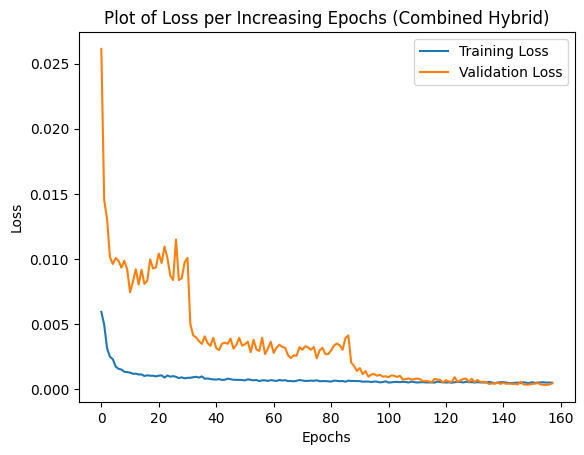

In [ ]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Loss per Increasing Epochs (Combined Hybrid)')
plt.legend()

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 60)         │        20,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40)             │        16,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,525 (431.74 KB)

 Trainable params: 36,841 (143.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 73,684 (287.83 KB)

### Testing & Forecasting

In [ ]:
## Predicting the test data
test_predict= model.predict(x_test)

## Comparing test values to actual valuesa
test_predict= target_scaler.inverse_transform(test_predict)
test_prices= y_test

print('Predicted', 'Actual')
for i in range(10):
    print(test_predict[i], test_prices[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Predicted Actual
[34.219955] [34.7]
[34.201805] [35.45]
[34.190033] [35.3]
[34.161304] [35.]
[34.11093] [35.05]
[34.049522] [34.75]
[33.97433] [34.2]
[33.883175] [34.]
[33.7734] [33.85]
[33.627193] [33.8]


In [ ]:
test_prices.shape

(729, 1)

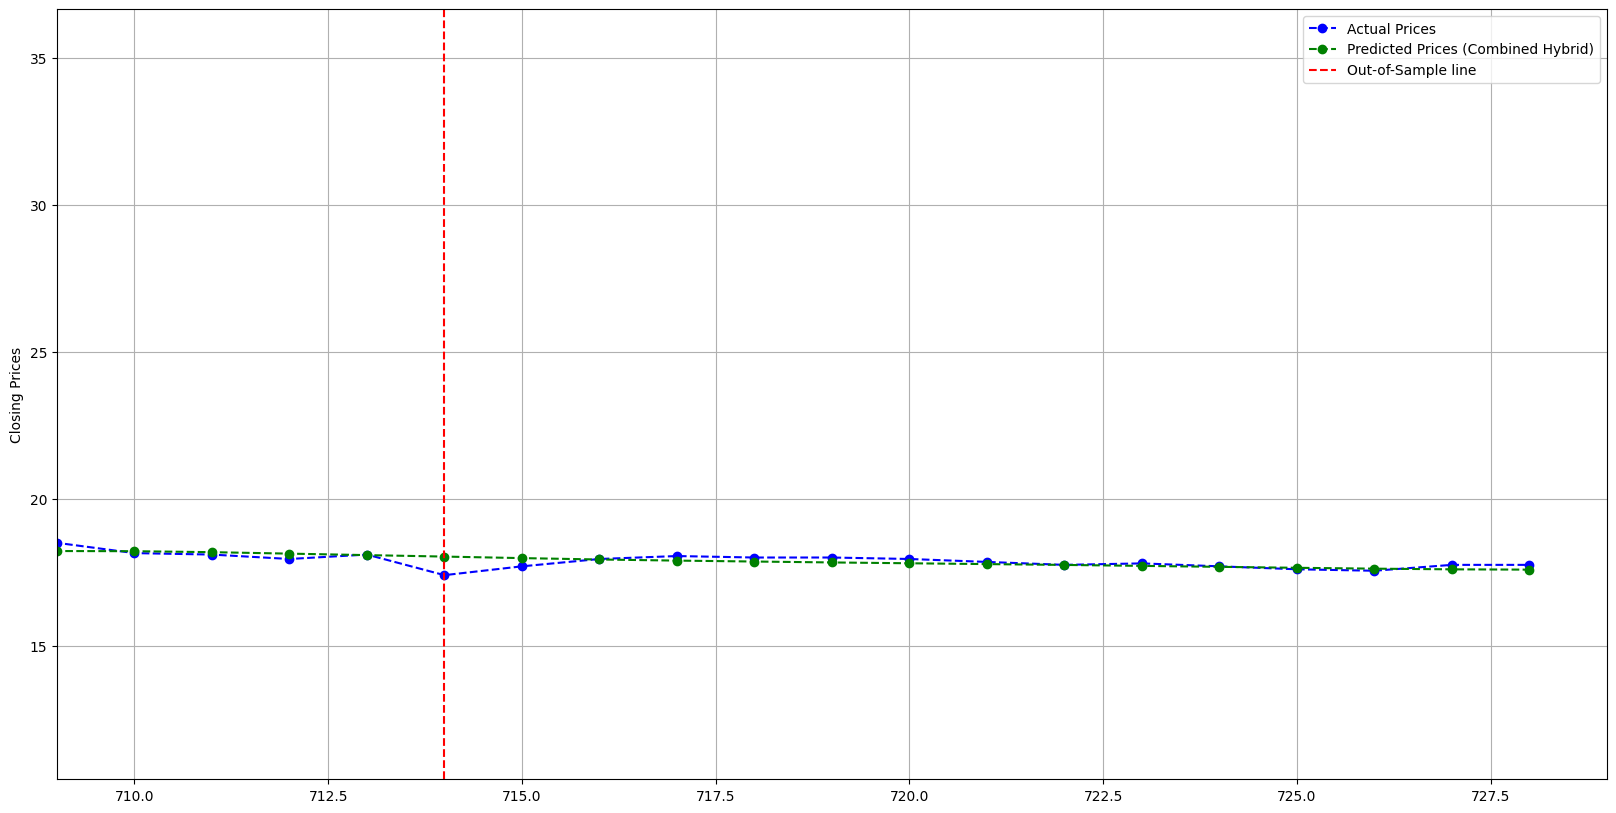

In [ ]:
## Plotting the predictions
plt.figure(figsize= (20,10))
plt.plot(test_prices, color= 'blue', label= 'Actual Prices', linestyle= '--', marker= 'o')
plt.plot(test_predict, color= 'green', label= 'Predicted Prices (Combined Hybrid)', linestyle= '--', marker= 'o')

plt.axvline(x= len(test_prices)-n, color= 'red', linestyle= '--', label= 'Out-of-Sample line')

plt.xlim(len(test_prices)-n-5, len(test_prices))

plt.ylabel('Closing Prices')
plt.legend()
plt.grid()

In [ ]:
# Compare only the last n days
print('mse=', mean_squared_error(test_prices[-n:], test_predict[-n:]))
print('rmse=', root_mean_squared_error(test_prices[-n:], test_predict[-n:]))
print('mae=', mean_absolute_error(test_prices[-n:], test_predict[-n:]))
print('mape=', mean_absolute_percentage_error(test_prices[-n:], test_predict[-n:]))
# print('r2=', r2_score(test_prices[-n:], test_predict[-n:]))

# We remove r2 as we are comparing short term predictions

mse= 0.0777186371779536
rmse= 0.27878062554265426
mae= 0.20952687581380214
mape= 0.011873065180010935
